In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import f1_score
import time

sys.path.insert(1, os.path.join(sys.path[0], "code/implementation"))
from layer_v2 import Layer
from neural_network_v2 import NeuralNetwork

In [3]:
def visualize_fit_of_regression(data_frame, neural, std):
    y = neural.predict(data_frame["x"])
    plt.scatter(data_frame["x"], y, c="red")
    plt.scatter(data_frame["x"], data_frame["y"], c="blue")
    plt.legend(["Prediction", "True"])
    return neural.calculate_cost(data_frame["x"], data_frame["y"]) * std["y"] ** 2

In [4]:
multimodal_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv"
)
mean = multimodal_train.mean()
std = multimodal_train.std()
multimodal_train = (multimodal_train - mean) / std
multimodal_test = (multimodal_test - mean) / std

# Joke but works surprisingly well  

In [5]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 20, "relu"))
neural.add_layer(Layer(20, 100, "relu"))
neural.add_layer(Layer(100, 1, "linear"))
mse = neural.train(multimodal_test["x"], multimodal_test["y"], max_num_epoch=1500, learning_rate=0.001)

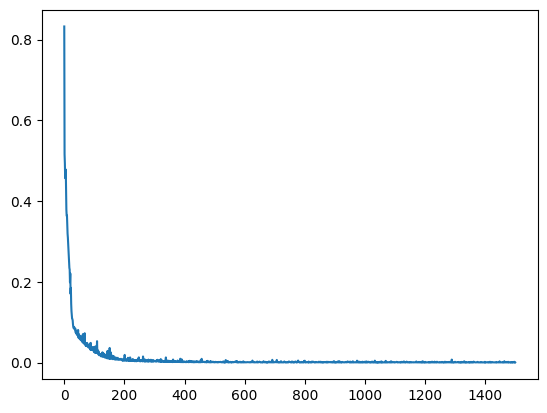

In [6]:
plt.plot(mse)

3.7861997579177413

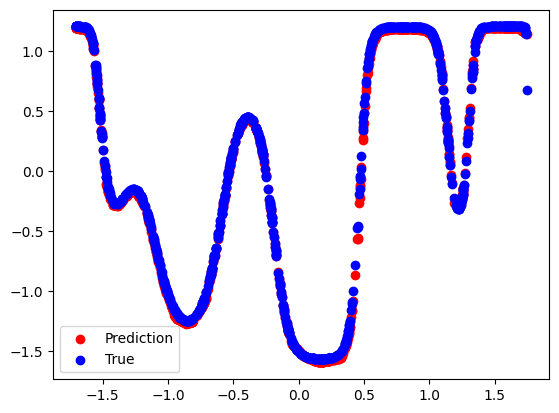

In [7]:
visualize_fit_of_regression(multimodal_test, neural, std)

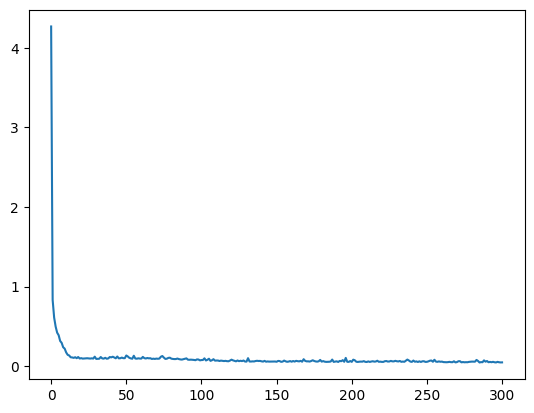

In [8]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 10, "relu"))
neural.add_layer(Layer(10, 1, "linear"))
mse = neural.train(
    multimodal_test["x"], multimodal_test["y"], max_num_epoch=300, learning_rate=0.01
)
plt.plot(mse)

257.7151700684677

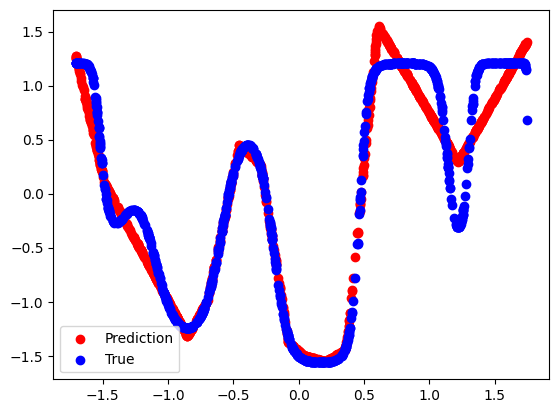

In [9]:
visualize_fit_of_regression(multimodal_test, neural, std)

In [10]:
activation_functions = ["relu", "sigmoid", "tanh", "linear", "leaky_relu"]
initialization_methods = [
    "normal",
    "uniform_xavier",
    "he",
    "normal_xavier",
    "uniform_minus_one_one",
    "uniform_zero_one",
]
number_of_repetition = 2 # 10

In [70]:
from collections import defaultdict 
df = pd.DataFrame(columns=["Initialization", "Activation", "Hidden Layers", "Cost", "Computation Time"])
after_epoch_dict = defaultdict(lambda: []) 

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="mse")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "linear"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="mse")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "linear"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="mse")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "linear"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third
            ]
            
            # Saving cost after epoch results
            after_epoch_dict[
                f"{initialization_method}/{activation}/1"
            ].append(one_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/2"
            ].append(two_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/3"
            ].append(three_cost_after_epoch)
    print(f"Initialization method {initialization_method} done")

Initialization method normal done
Initialization method uniform_xavier done
Initialization method he done
Initialization method normal_xavier done
Initialization method uniform_minus_one_one done
Initialization method uniform_zero_one done


### saving results

This trick was used because calculations were done on google colab thats, why saving part is commented out, i don't want to overwrite it 

In [82]:
# df.to_csv("results.csv", index=False)

# import dill
# with open("after_epoch_dict.pkl", "wb") as f:
#     dill.dump(after_epoch_dict, f)

### loading results

In [88]:
df = pd.read_csv("results.csv")
after_epoch_dict = dill.load(open("after_epoch_dict.pkl", "rb"))

Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization')

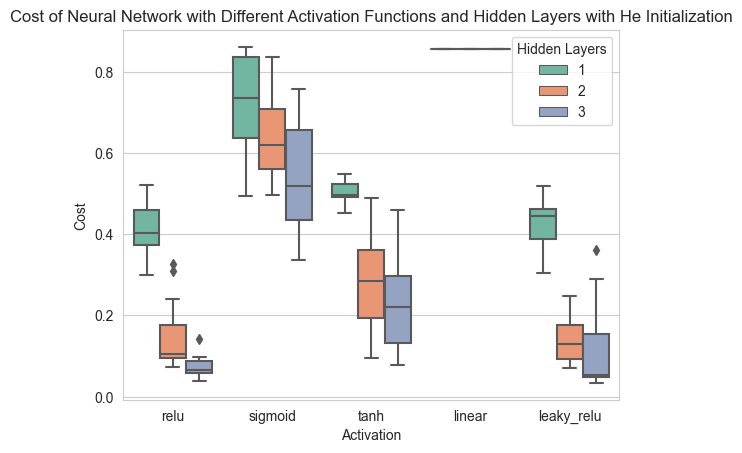

In [101]:
import seaborn as sns
sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "he"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers", palette="Set2")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with Normal Xavier Initialization')

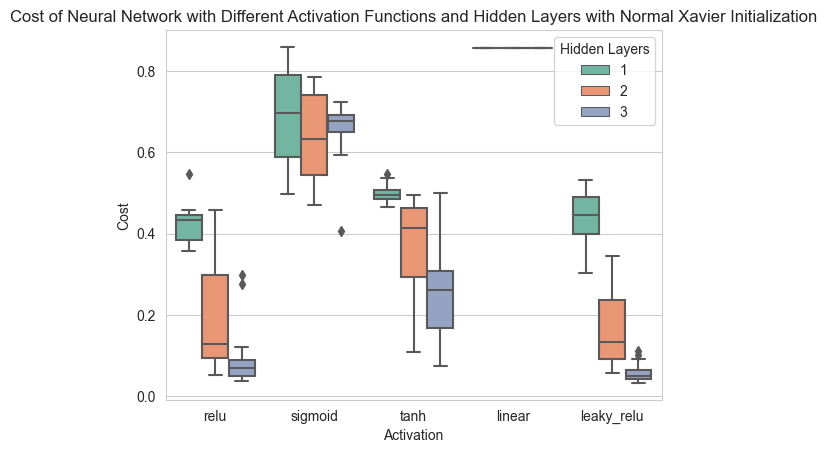

In [102]:
import seaborn as sns

sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "normal_xavier"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers", palette="Set2")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with Normal Xavier Initialization"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Initialization Functions and Hidden Layers with ReLU Activation')

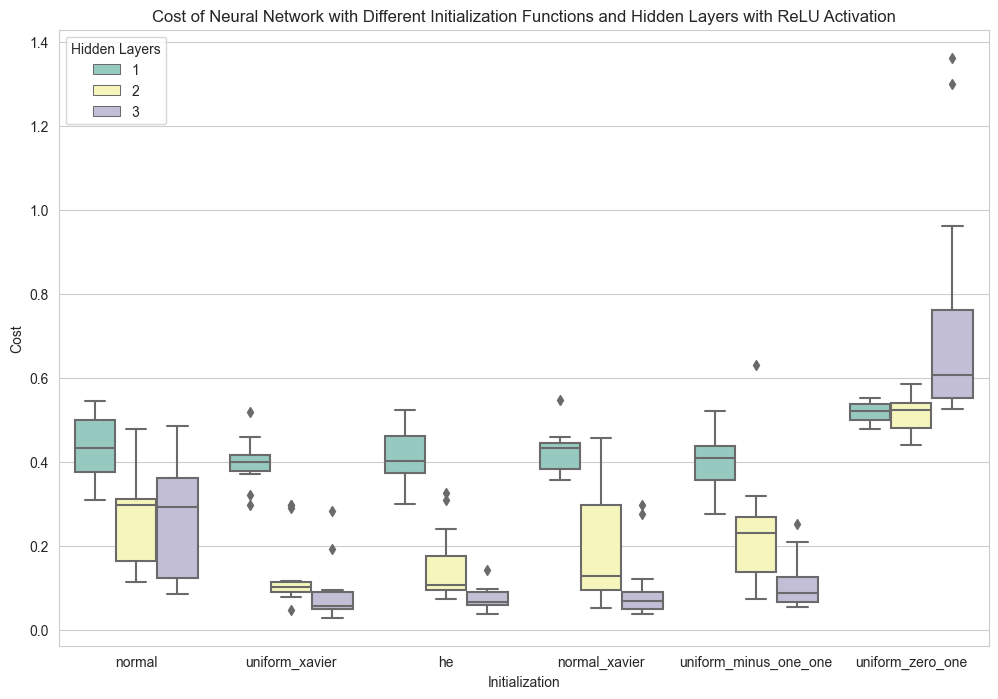

In [106]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
df_he = df[df["Activation"] == "relu"]
sns.boxplot(
    x="Initialization", y="Cost", data=df_he, hue="Hidden Layers", palette="Set3"
)
plt.title(
    "Cost of Neural Network with Different Initialization Functions and Hidden Layers with ReLU Activation"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Initialization Functions and Hidden Layers with sigmoid Activation')

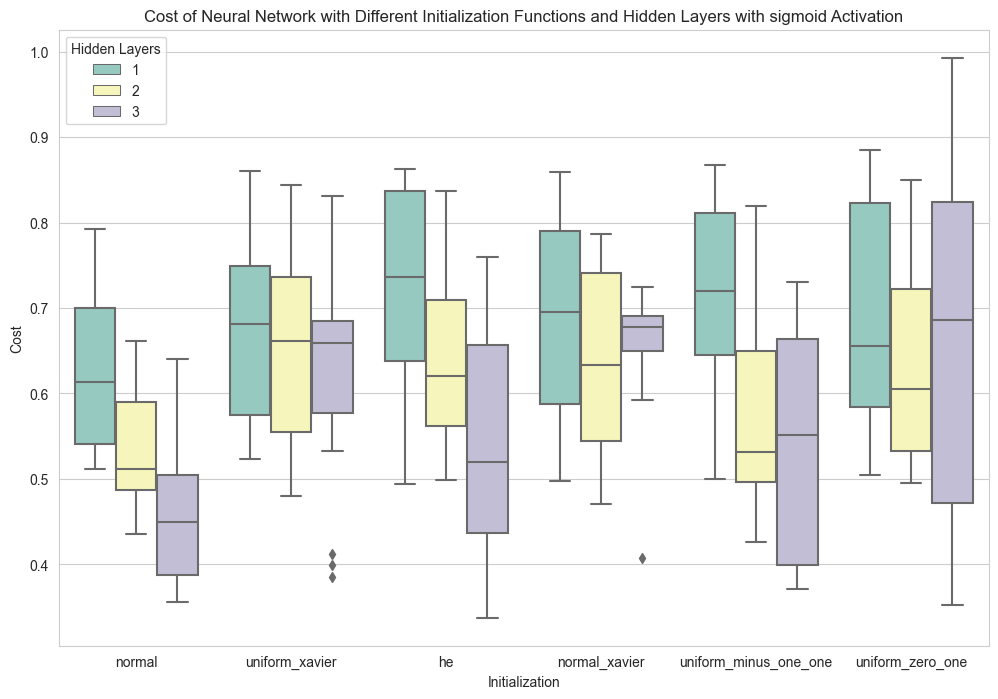

In [112]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
df_sigmoid = df[df["Activation"] == "sigmoid"]
sns.boxplot(
    x="Initialization", y="Cost", data=df_sigmoid, hue="Hidden Layers", palette="Set3"
)
plt.title(
    "Cost of Neural Network with Different Initialization Functions and Hidden Layers with sigmoid Activation"
)

Text(0.5, 1.0, 'Time of computing 200 epoch of Neural Network with different activation function and Hidden Layer')

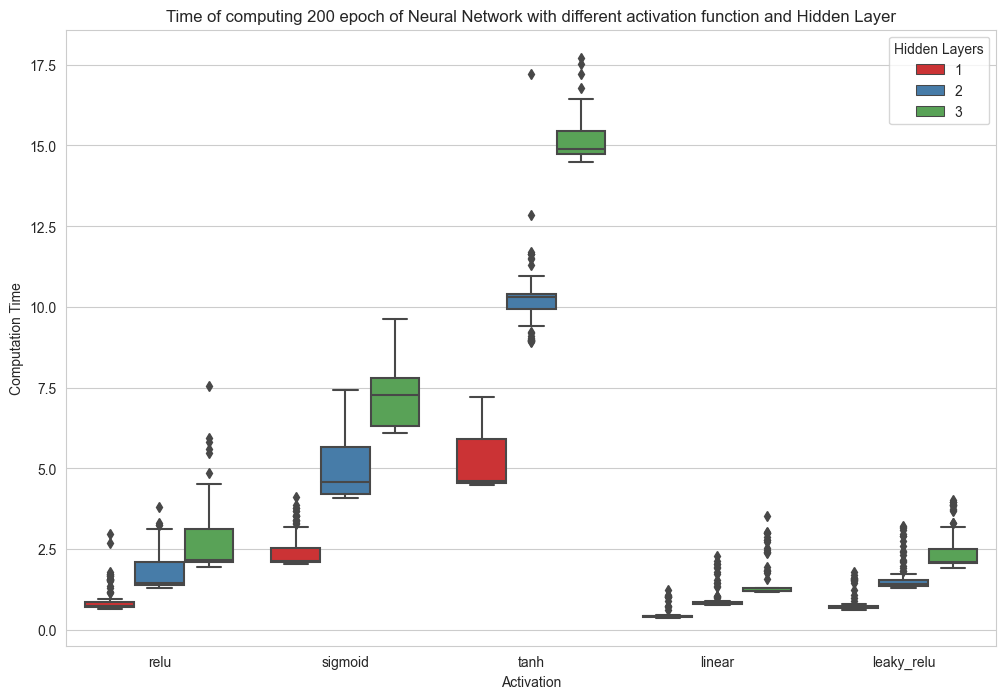

In [118]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(
    x="Activation", y="Computation Time", data=df, hue="Hidden Layers", palette="Set1"
)
plt.title(
    "Time of computing 200 epoch of Neural Network with different activation function and Hidden Layer"
)

Text(0, 0.5, 'MSE')

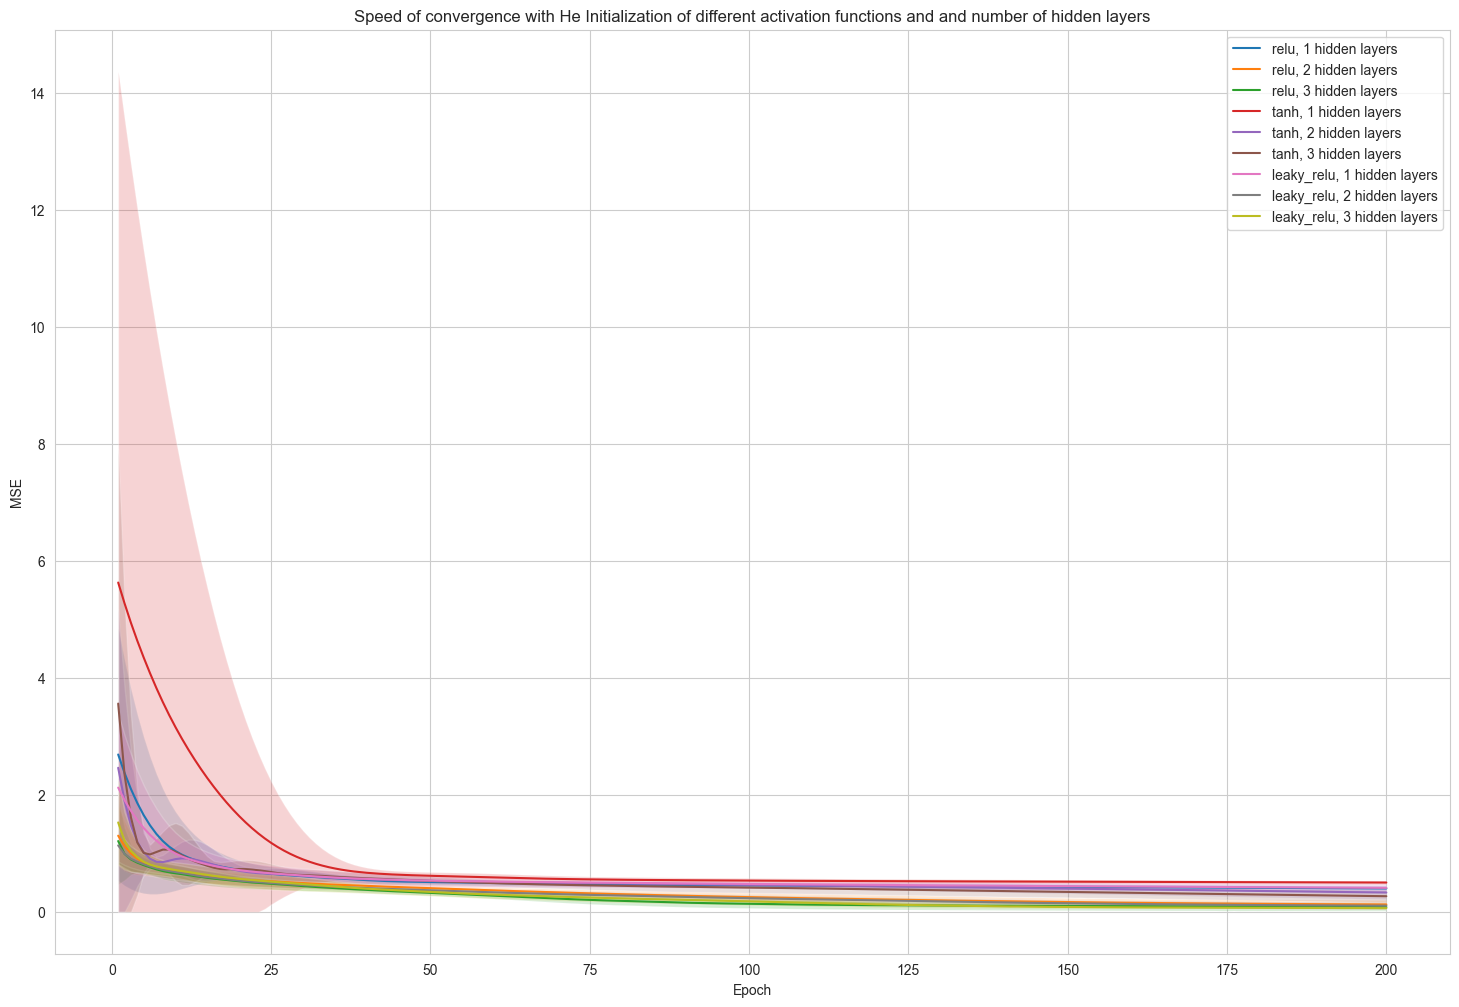

In [98]:
plt.figure(figsize=(18, 12))
start = 1
stop = len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key  = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if key[0] == "uniform_xavier" and key[1] not in ["linear", "sigmoid"]:
        plt.plot(range(start,stop), np.mean(value, axis=0)[start:stop], label=label)
                                                      
        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value,axis=0)[start:stop],
            alpha=0.2,
        )

plt.legend()
plt.title("Speed of convergence with He Initialization of different activation functions and and number of hidden layers")
plt.xlabel("Epoch")
plt.ylabel("MSE")